## Librairies

In [552]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings("ignore")


## Reading CSV Files

In [553]:
train_path = r'C:\Users\benze\OneDrive\Bureau\M2 MOSEF 2024-2025\Data Mining\Challenge_kaggle\data\train.csv'
test_path = r'C:\Users\benze\OneDrive\Bureau\M2 MOSEF 2024-2025\Data Mining\Challenge_kaggle\data\test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_overview = train_data.head(), train_data.info(), train_data.describe()
test_overview = test_data.head(), test_data.info(), test_data.describe()

train_overview, test_overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (tot

((   id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
  0   0  15713774.0      Hsieh        683.0   Germany    Male  49.0     7.0   
  1   1  15682533.0      Hs?eh        608.0    France  Female  30.0    10.0   
  2   2  15791550.0       Tsou        539.0    France  Female  32.0     8.0   
  3   3  15762762.0  Chiawuotu        530.0     Spain  Female  39.0     8.0   
  4   4  15756475.0     Nnamdi        613.0    France  Female  45.0    10.0   
  
       Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
  0  123837.86            2.0        1.0             1.0        138700.75   
  1       0.00            2.0        1.0             1.0        146723.72   
  2       0.00            1.0        1.0             1.0         94873.60   
  3       0.00            2.0        0.0             0.0        177896.93   
  4       0.00            2.0        1.0             1.0        116748.14   
  
     Exited  
  0     1.0  
  1     0.0  
  2     0.0  
  

In [554]:
test=pd.read_csv(test_path)

## Colonnes à supprimer 

In [555]:
train_data= train_data.drop(columns=["id", "CustomerId", "Surname",])
test_data= test_data.drop(columns=["id", "CustomerId", "Surname",])

##  Encoding Categorical Variables

In [556]:
train_encoded = pd.get_dummies(train_data, columns=["Geography", "Gender"], drop_first=True)
test_encoded =  pd.get_dummies(test_data, columns=["Geography", "Gender"], drop_first=True)

## Histogramme var num

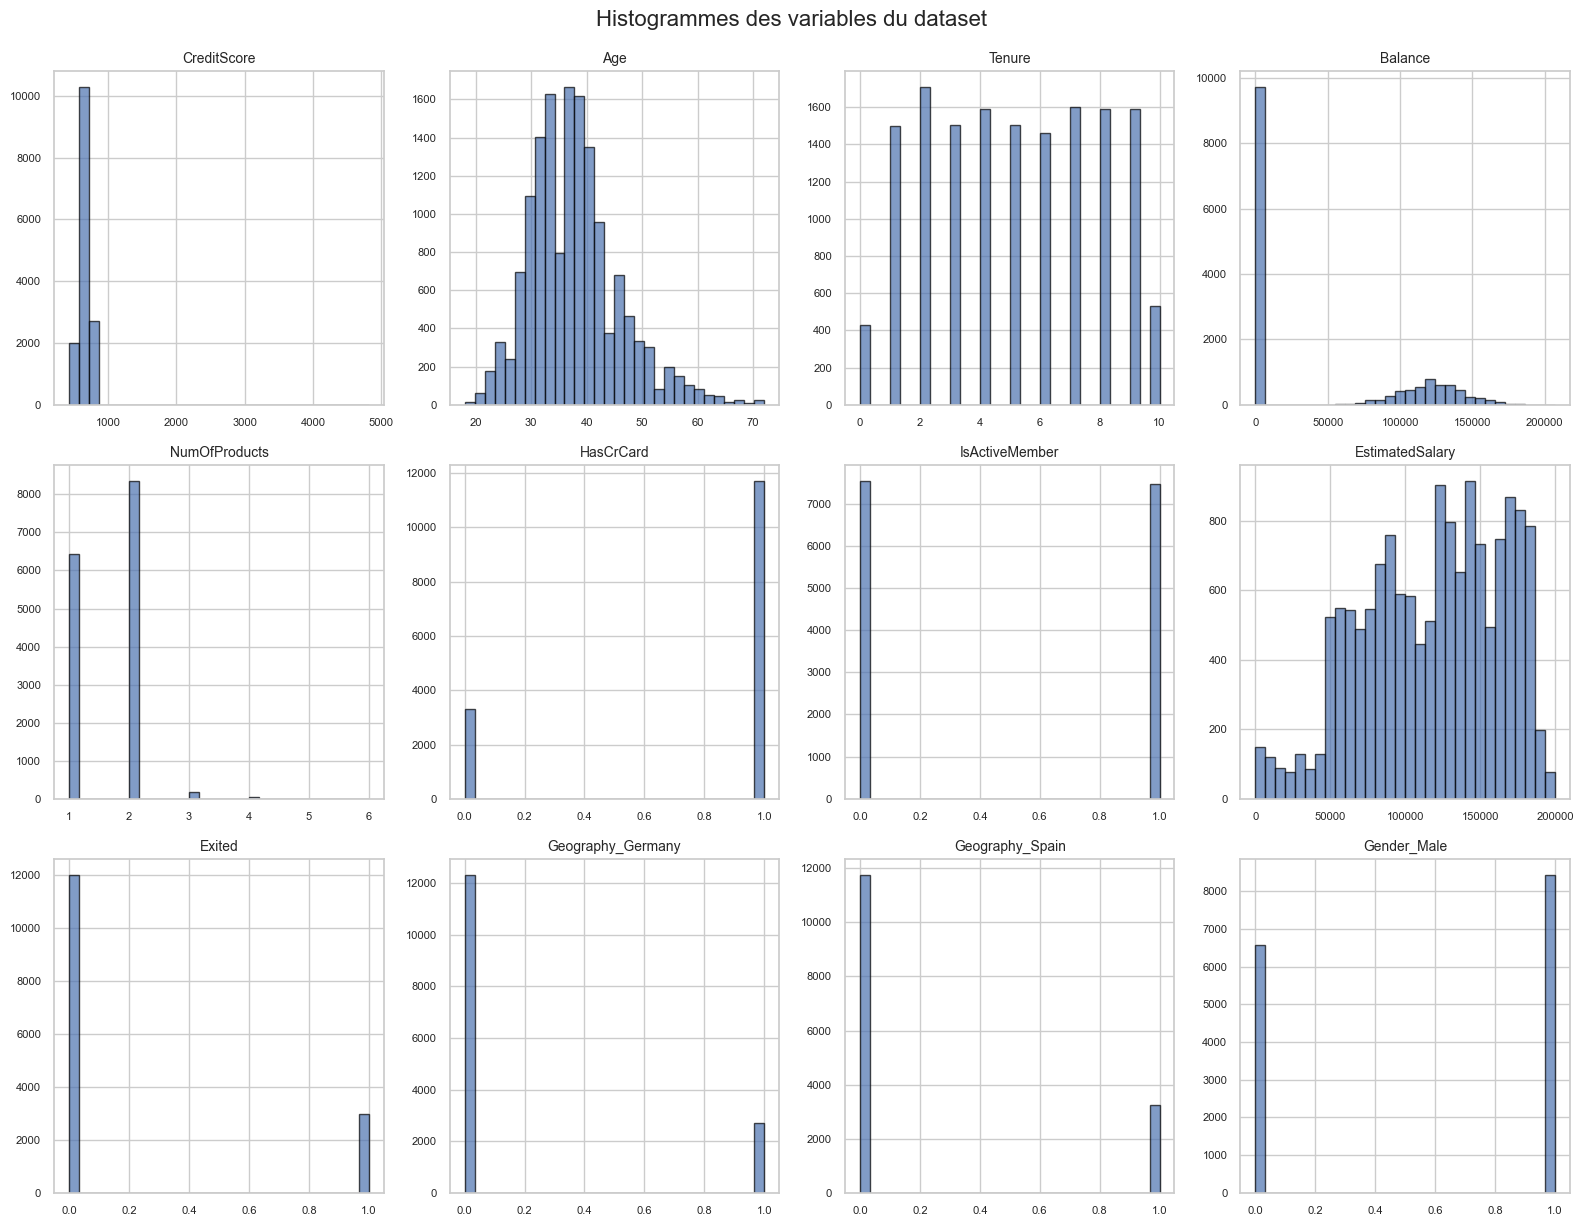

In [557]:
columns = train_encoded.columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(columns, 1):
    plt.subplot((len(columns) + 3) // 4, 4, i) 
    train_encoded[col].hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title(col, fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()

plt.suptitle("Histogrammes des variables du dataset", fontsize=16, y=1.02)
plt.show()


## Vérification des outliers de la variable Crédit Score

Nombre d'outliers dans CreditScore : 16
Statistiques des outliers :
       CreditScore        Age     Tenure        Balance  NumOfProducts  \
count     16.00000  16.000000  16.000000      16.000000      16.000000   
mean     709.37500  40.937500   4.687500   71709.370625       1.437500   
std     1095.63795   8.582686   3.156343   66884.876606       0.512348   
min      431.00000  32.000000   1.000000       0.000000       1.000000   
25%      433.25000  33.750000   1.750000       0.000000       1.000000   
50%      437.50000  40.000000   4.500000  101723.590000       1.000000   
75%      438.25000  43.500000   8.000000  129774.520000       2.000000   
max     4818.00000  60.000000   9.000000  162261.010000       2.000000   

       HasCrCard  IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
count  16.000000       16.000000         16.00000  16.000             16.000   
mean    0.687500        0.437500     126804.29125   0.375              0.375   
std     0.478714        0

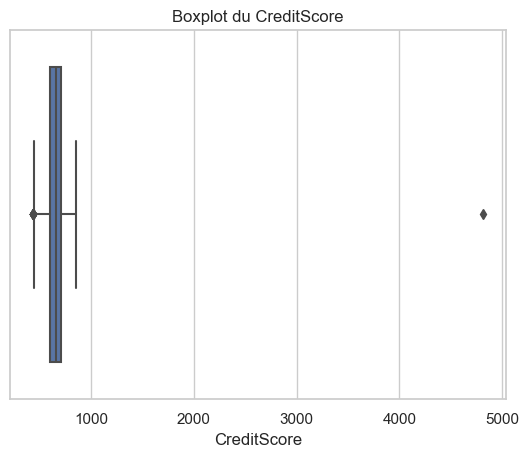

Proportion de churn pour les outliers :
0.0    0.625
1.0    0.375
Name: Exited, dtype: float64
Proportion de churn pour les non-outliers :
0.0    0.800854
1.0    0.199146
Name: Exited, dtype: float64


In [558]:
Q1 = train_encoded["CreditScore"].quantile(0.25)
Q3 = train_encoded["CreditScore"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_encoded[(train_encoded["CreditScore"] < lower_bound) | 
                         (train_encoded["CreditScore"] > upper_bound)]
print(f"Nombre d'outliers dans CreditScore : {len(outliers)}")

print("Statistiques des outliers :")
print(outliers.describe())
print("Statistiques des non-outliers :")
print(train_encoded[(train_encoded["CreditScore"] >= lower_bound) & 
                    (train_encoded["CreditScore"] <= upper_bound)].describe())

sns.boxplot(x=train_encoded["CreditScore"])
plt.title("Boxplot du CreditScore")
plt.show()

outliers_exited = outliers["Exited"].value_counts(normalize=True)
non_outliers_exited = train_encoded[(train_encoded["CreditScore"] >= lower_bound) & 
                                    (train_encoded["CreditScore"] <= upper_bound)]["Exited"].value_counts(normalize=True)

print("Proportion de churn pour les outliers :")
print(outliers_exited)
print("Proportion de churn pour les non-outliers :")
print(non_outliers_exited)


## Matrice de correlation

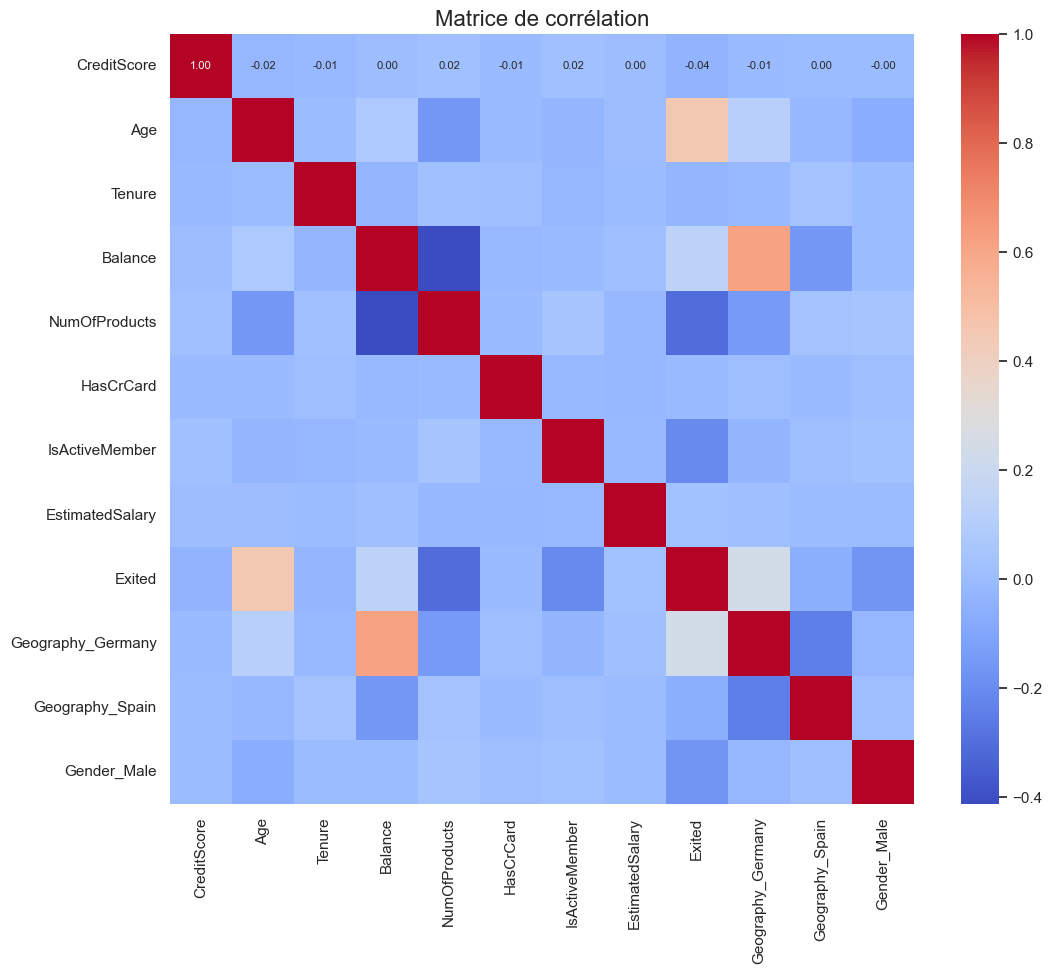

In [559]:
correlation_matrix = train_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Matrice de corrélation", fontsize=16)
plt.show()

## Distribution de la variable cible 

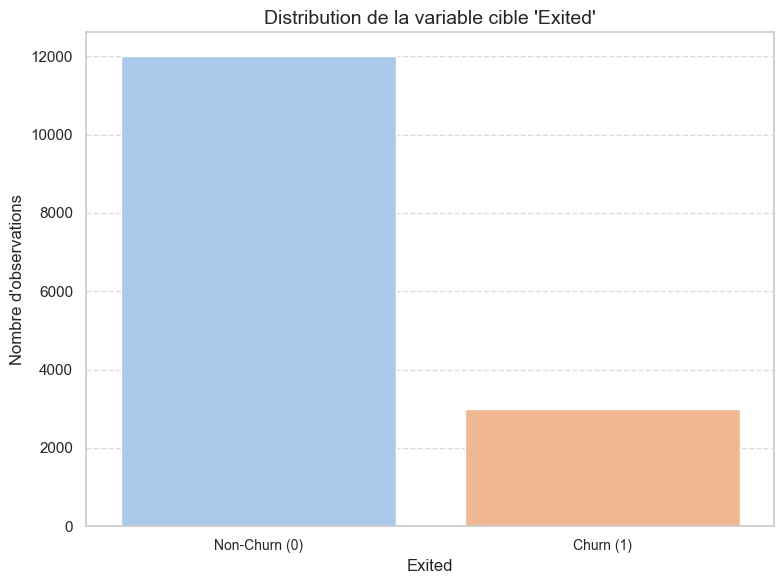

In [599]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Exited', data=train_encoded, palette='pastel')
plt.title("Distribution de la variable cible 'Exited'", fontsize=14)
plt.xlabel("Exited", fontsize=12)
plt.ylabel("Nombre d'observations", fontsize=12)
plt.xticks([0, 1], ['Non-Churn (0)', 'Churn (1)'], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Model 1 

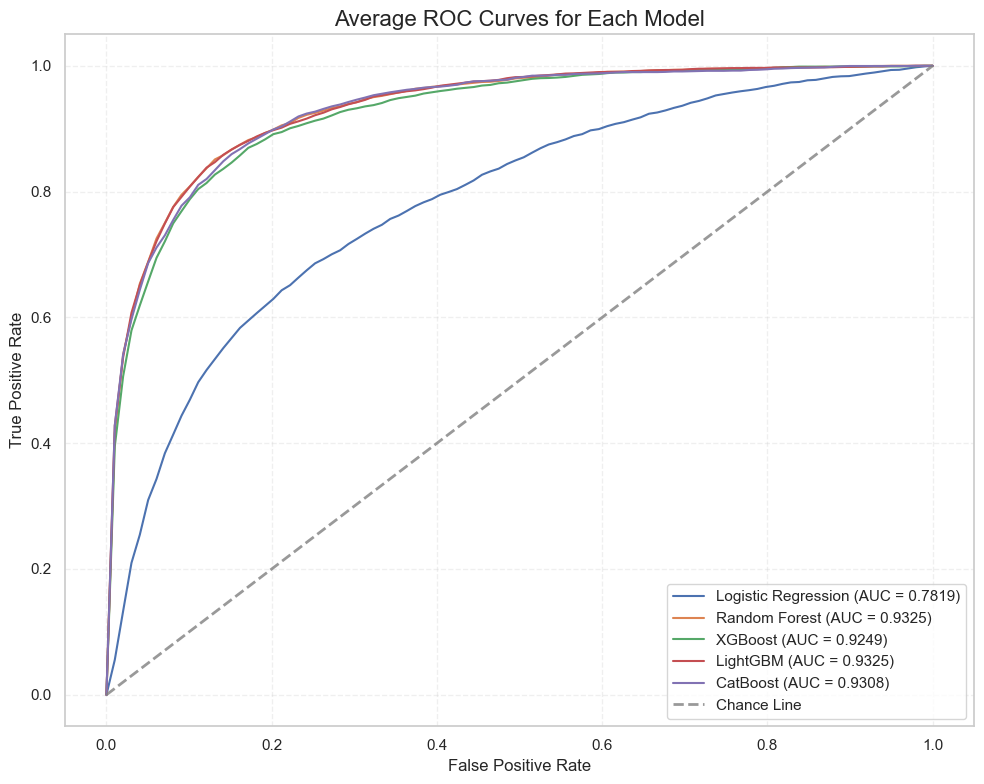

Logistic Regression: Average AUC = 0.7819
Random Forest: Average AUC = 0.9325
XGBoost: Average AUC = 0.9249
LightGBM: Average AUC = 0.9325
CatBoost: Average AUC = 0.9308


In [560]:
X = train_encoded.drop(columns=["Exited"]).values
y = train_encoded["Exited"]
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)
}


plt.figure(figsize=(10, 8))
mean_auc_scores = {}

for name, model in models.items():
    tprs = []  
    mean_fpr = np.linspace(0, 1, 100) 
    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_val, y_val_pred)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 
        tprs.append(interp_tpr)
        auc_scores.append(roc_auc_score(y_val, y_val_pred))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 
    mean_auc = np.mean(auc_scores)
    mean_auc_scores[name] = mean_auc
    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.4f})")


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8, label="Chance Line")
plt.title("Average ROC Curves for Each Model", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("roc_curves_comparison_fixed.png", dpi=300)
plt.show()

# Print average AUCs
for model, auc in mean_auc_scores.items():
    print(f"{model}: Average AUC = {auc:.4f}")


## transformation logarithmique pour la variable Balance

In [561]:
train_encoded["Log_Balance"] = np.log1p(train_encoded["Balance"])
test_encoded["Log_Balance"] = np.log1p(test_encoded["Balance"])

## model 2 

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


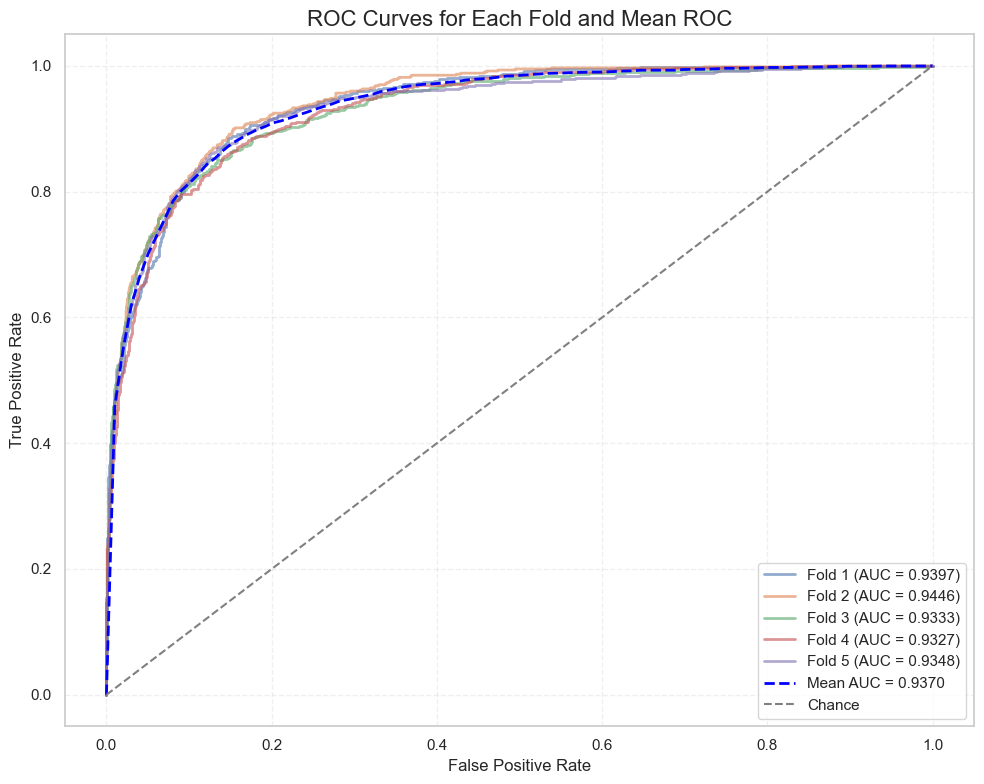

Mean AUC across folds: 0.9370
Fichier de soumission enregistré : 'resultats\submission_catboost_kfold_with_roc.csv'


In [562]:
X = train_encoded.drop(columns=["Exited"])  
y = train_encoded["Exited"]  

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))
mean_fpr = np.linspace(0, 1, 100)
tprs = []

plt.figure(figsize=(10, 8))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()
print(f"Mean AUC across folds: {mean_auc:.4f}")

submission = pd.DataFrame({
    'id': test['id'],  
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost1_kfold_with_roc.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost_kfold_with_roc.csv'")


## LGBM1

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


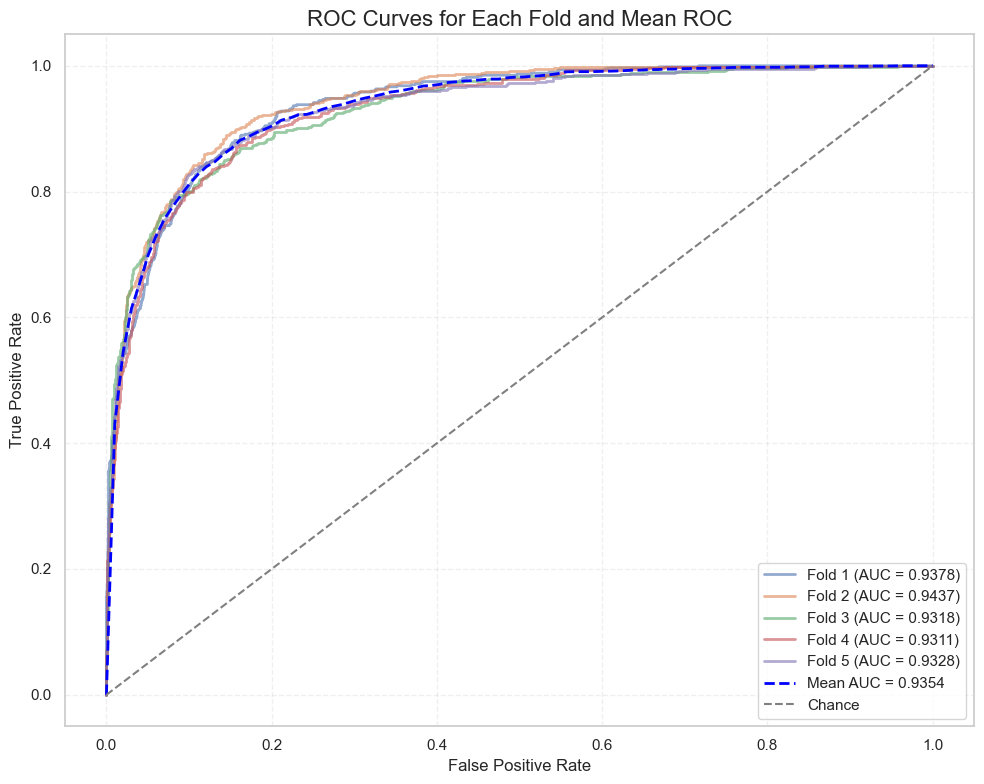

Mean AUC across folds: 0.9354
Fichier de soumission enregistré : 'resultats\submission_LGBM1_kfold_with_roc.csv'


In [563]:
X = train_encoded.drop(columns=["Exited"])  
y = train_encoded["Exited"]  

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))
mean_fpr = np.linspace(0, 1, 100)
tprs = []

plt.figure(figsize=(10, 8))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model =LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()
print(f"Mean AUC across folds: {mean_auc:.4f}")

submission = pd.DataFrame({
    'id': test['id'],  
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_LGBM1_kfold_with_roc.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_LGBM1_kfold_with_roc.csv'")


## Age Binned

In [564]:
bins = [0, 25, 40, 60, 100]  
labels = [1, 2, 3, 4]  
train_encoded["Age_Group"] = pd.cut(train_encoded["Age"], bins=bins, labels=labels, right=False).astype(int)
test_encoded["Age_Group"] = pd.cut(test_encoded["Age"], bins=bins, labels=labels, right=False).astype(int)

## Model 3

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


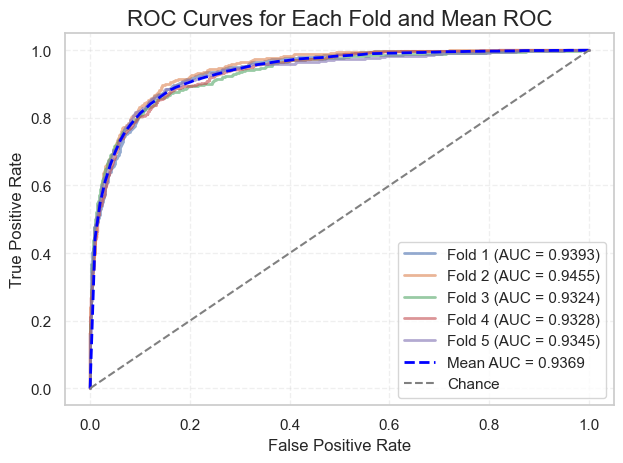

Mean AUC across folds: 0.9369034026828256
Fichier de soumission enregistré : 'resultats\submission_catboost_kfold2.csv'


In [565]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost_kfold2.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost_kfold2.csv'")
    

In [566]:
train_encoded = train_encoded.drop(columns=["Age_Group"])

In [567]:
test_encoded = test_encoded.drop(columns=["Age_Group"])

## Solde elevé mais client inactif

In [568]:
train_encoded['Inactive_high_balance'] = ((train_encoded['Balance'] > 100000) & (train_encoded['IsActiveMember'] == 0)).astype(int)
test_encoded['Inactive_high_balance'] = ((test_encoded['Balance'] > 100000) & (test_encoded['IsActiveMember'] == 0)).astype(int)

## Model 4

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


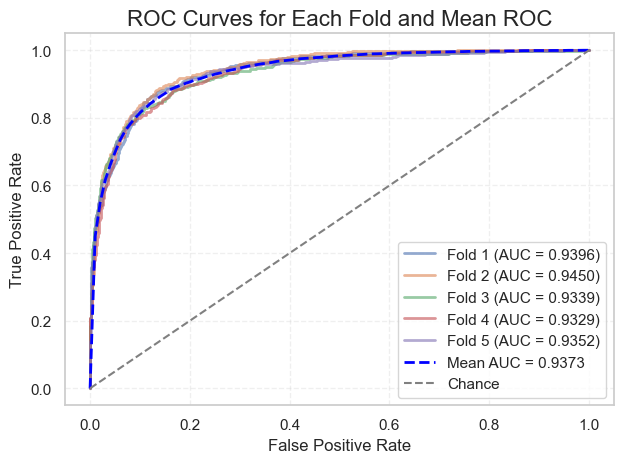

Mean AUC across folds: 0.9373250830550907
Fichier de soumission enregistré : 'resultats\submission_catboost_kfold3.csv'


In [569]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost3_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost_kfold3.csv'")
    

## Clients ayant de nombreux produits mais un faible solde

In [570]:
train_encoded['Low_balance_high_products'] = ((train_encoded['Balance'] < 5000) & (train_encoded['NumOfProducts'] > 2)).astype(int)
test_encoded['Low_balance_high_products'] = ((test_encoded['Balance'] < 5000) & (test_encoded['NumOfProducts'] > 2)).astype(int)


## Model 5 

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


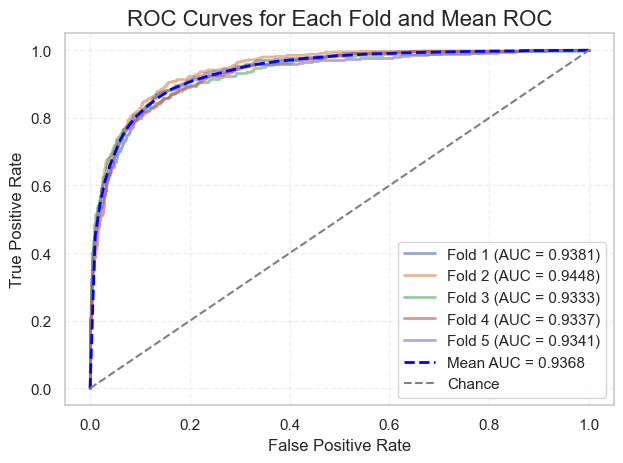

Mean AUC across folds: 0.9368201387361147
Fichier de soumission enregistré : 'resultats\submission_catboost4_kfold.csv'


In [571]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost4_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost4_kfold.csv'")
    

In [572]:
train_encoded = train_encoded.drop(columns=["Low_balance_high_products"])
test_encoded = test_encoded.drop(columns=["Low_balance_high_products"])

## Clients avec un age  avancé mais un faible solde

In [573]:
train_encoded['Senior_low_balance'] = ((train_encoded['Age'] > 60) & (train_encoded['Balance'] < 20000)).astype(int)
test_encoded['Senior_low_balance'] = ((test_encoded['Age'] > 60) & (test_encoded['Balance'] < 20000)).astype(int)
train_model['Senior_low_balance'] = train_encoded["Senior_low_balance"]
test_model['Senior_low_balance'] = test_encoded["Senior_low_balance"]


## model 6

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


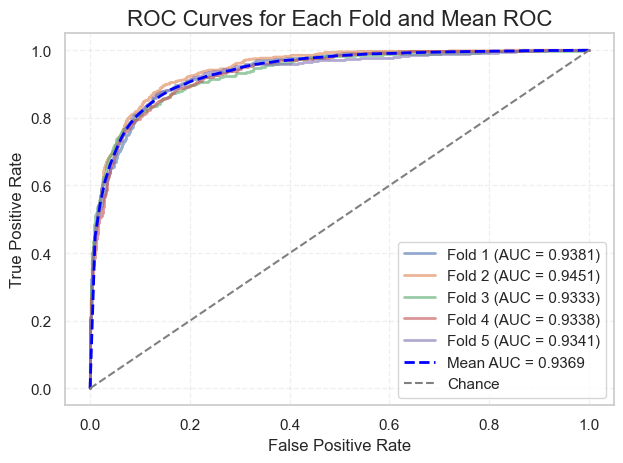

Mean AUC across folds: 0.9368967192891097
Fichier de soumission enregistré : 'resultats\submission_catboost5_kfold.csv'


In [574]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost5_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost5_kfold.csv'")
    

In [575]:
train_encoded = train_encoded.drop(columns=["Senior_low_balance"])
test_encoded = test_encoded.drop(columns=["Senior_low_balance"])

## Salaires elevés mais peu de produits utilisés 

In [576]:
train_encoded['High_salary_low_products'] = ((train_encoded['EstimatedSalary'] > 150000) & (train_encoded['NumOfProducts'] == 1)).astype(int)
test_encoded['High_salary_low_products'] = ((test_encoded['EstimatedSalary'] > 150000) & (test_encoded['NumOfProducts'] == 1)).astype(int)

## Model 7 

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


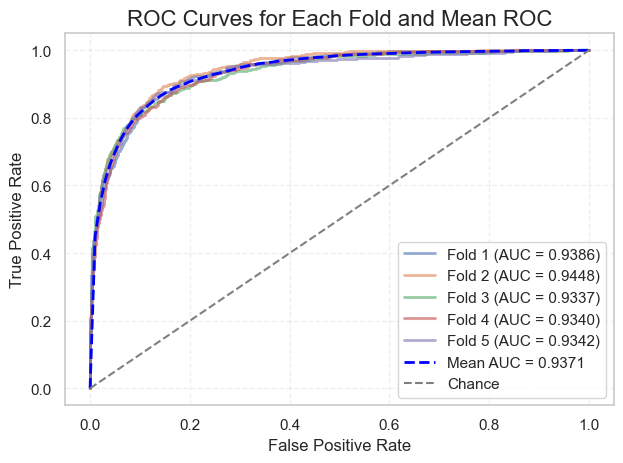

Mean AUC across folds: 0.9370718102807304
Fichier de soumission enregistré : 'resultats\submission_catboost6_kfold.csv'


In [577]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost6_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost6_kfold.csv'")
    

## Tenure faible et inactive

In [578]:
train_encoded['Low_tenure_inactive'] = ((train_encoded['Tenure'] < 3) & (train_encoded['IsActiveMember'] == 0)).astype(int)
test_encoded['Low_tenure_inactive'] = ((test_encoded['Tenure'] < 3) & (test_encoded['IsActiveMember'] == 0)).astype(int)

## Model 8 

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


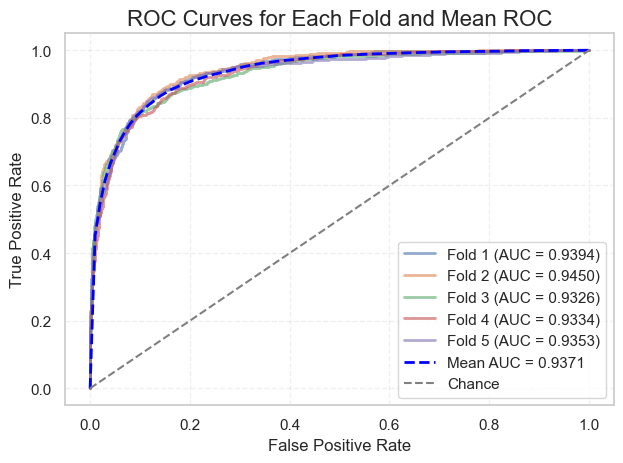

Mean AUC across folds: 0.9371084297087992
Fichier de soumission enregistré : 'resultats\submission_catboost7_kfold.csv'


In [579]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost7_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost7_kfold.csv'")
    

In [580]:
train_encoded = train_encoded.drop(columns=["Low_tenure_inactive"])
test_encoded = test_encoded.drop(columns=["Low_tenure_inactive"]) 

train_encoded = train_encoded.drop(columns=["High_salary_low_products"])
test_encoded = test_encoded.drop(columns=["High_salary_low_products"])          


## creation variable multiplication age et balance

In [581]:
train_encoded['Age_Balance'] = train_encoded['Age'] * train_encoded['Balance']
test_encoded['Age_Balance'] = test_encoded['Age'] * test_encoded['Balance']
train_model['Age_Balance'] = train_encoded["Age_Balance"]
test_model['Age_Balance'] = test_encoded["Age_Balance"]



## Model 9

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


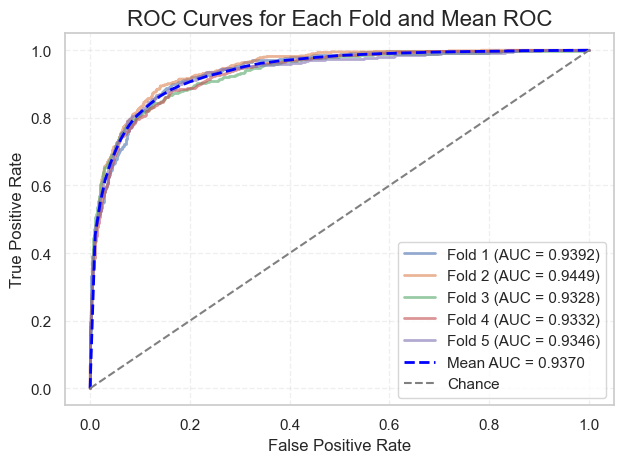

Mean AUC across folds: 0.9369507433883136
Fichier de soumission enregistré : 'resultats\submission_catboost8_kfold.csv'


In [582]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost8_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost8_kfold.csv'")
    

## Importance de l'engagement client

In [583]:
train_encoded['Tenure_NumOfProducts'] = train_encoded['Tenure'] * train_encoded['NumOfProducts']
test_encoded['Tenure_NumOfProducts'] = test_encoded['Tenure'] * test_encoded['NumOfProducts']

## Model 10

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


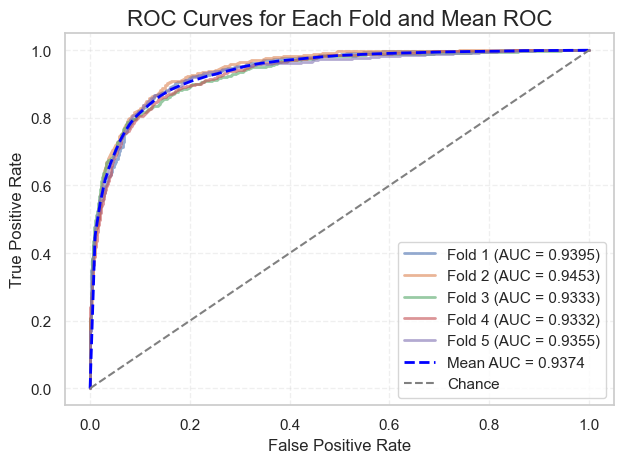

Mean AUC across folds: 0.9373800818158781
Fichier de soumission enregistré : 'resultats\submission_catboost9_kfold.csv'


In [584]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost9_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost9_kfold.csv'")
    

## Influence de l'activité et des produits utilisés

In [585]:
train_encoded['NumOfProducts_IsActiveMember'] = train_encoded['NumOfProducts'] * train_encoded['IsActiveMember']
test_encoded['NumOfProducts_IsActiveMember'] = test_encoded['NumOfProducts'] * test_encoded['IsActiveMember']

## Model 11

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


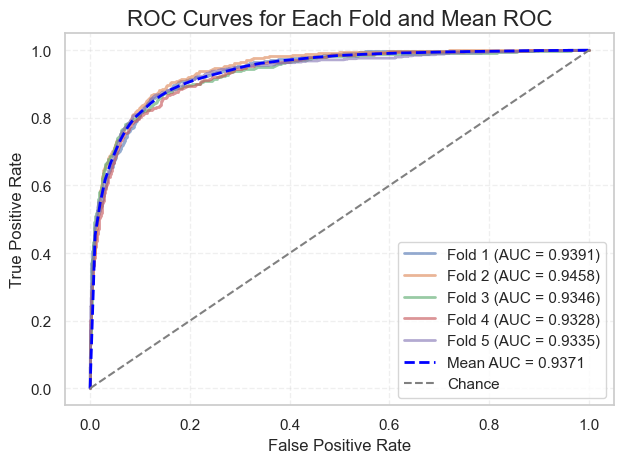

Mean AUC across folds: 0.9371441440939684
Fichier de soumission enregistré : 'resultats\submission_catboost10_kfold.csv'


In [586]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost10_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost10_kfold.csv'")

## Ratio entre solde et salaire estimé

In [587]:
train_encoded['Balance / EstimatedSalary'] = train_encoded['Balance'] / train_encoded['EstimatedSalary']
test_encoded['Balance / EstimatedSalary'] = test_encoded['Balance'] / test_encoded['EstimatedSalary']

## Model 12

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


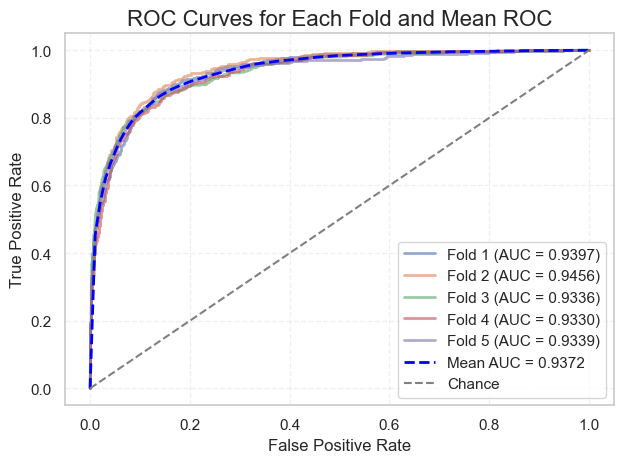

Mean AUC across folds: 0.9371809723780906
Fichier de soumission enregistré : 'resultats\submission_catboost11_kfold.csv'


In [588]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost11_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost11_kfold.csv'")

## relation avancée 

In [589]:
train_encoded['Balance_per_Product_Age'] = train_encoded['Balance'] / (train_encoded['NumOfProducts'] * train_encoded['Age'] + 1)
test_encoded['Balance_per_Product_Age'] = test_encoded['Balance'] / (test_encoded['NumOfProducts'] * test_encoded['Age'] + 1)

## Model 13

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


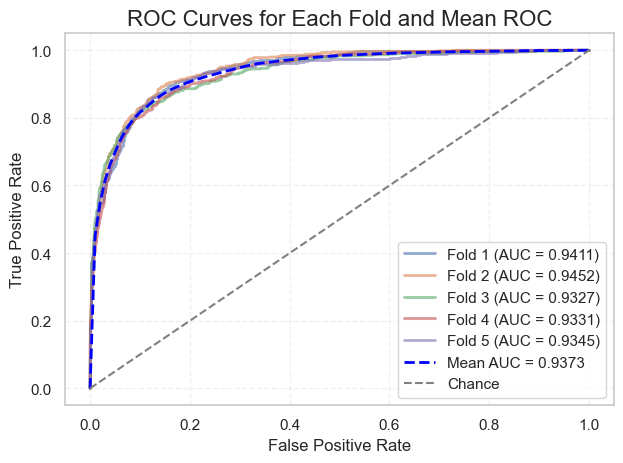

Mean AUC across folds: 0.937316519956892
Fichier de soumission enregistré : 'resultats\submission_catboost12_kfold.csv'


In [590]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost12_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost12_kfold.csv'")

## encore des variables :) 

In [591]:
train_encoded['Balance_Tenure'] = train_encoded['Balance'] * train_encoded['Tenure']
test_encoded['Balance_Tenure'] = test_encoded['Balance'] * test_encoded['Tenure']

train_encoded['Balance_per_Product'] = train_encoded['Balance'] / (train_encoded['NumOfProducts'] + 1)
test_encoded['Balance_per_Product'] = test_encoded['Balance'] / (test_encoded['NumOfProducts'] + 1)

train_encoded['Age_CreditScore'] = train_encoded['Age'] * train_encoded['CreditScore']
test_encoded['Age_CreditScore'] = test_encoded['Age'] * test_encoded['CreditScore']

train_encoded['Age_Tenure_Ratio'] = train_encoded['Tenure'] / (train_encoded['Age'] + 1)
test_encoded['Age_Tenure_Ratio'] = test_encoded['Tenure'] / (test_encoded['Age'] + 1)

train_encoded['Age_Active'] = train_encoded['Age'] * train_encoded['IsActiveMember']
test_encoded['Age_Active'] = test_encoded['Age'] * test_encoded['IsActiveMember']


## Model 14

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


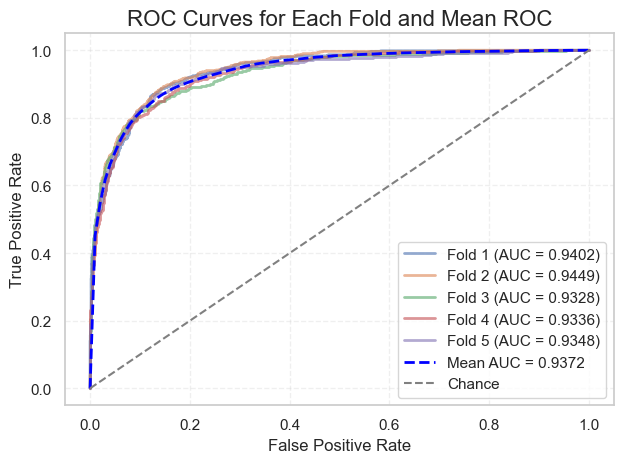

Mean AUC across folds: 0.9372482240273575
Fichier de soumission enregistré : 'resultats\submission_catboost13_kfold.csv'


In [592]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model =  CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost13_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost13_kfold.csv'")

In [593]:
columns_to_drop = [
    'Balance_Tenure',
    'Balance_per_Product',
    'Age_CreditScore',
    'Age_Tenure_Ratio',
    'Age_Active'
]

train_encoded = train_encoded.drop(columns=columns_to_drop, errors='ignore')
test_encoded = test_encoded.drop(columns=columns_to_drop, errors='ignore')

print("Colonnes restantes dans train_model :", train_encoded.columns)
print("Colonnes restantes dans test_model :", test_encoded.columns)


Colonnes restantes dans train_model : Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'Log_Balance',
       'Inactive_high_balance', 'Age_Balance', 'Tenure_NumOfProducts',
       'NumOfProducts_IsActiveMember', 'Balance / EstimatedSalary',
       'Balance_per_Product_Age'],
      dtype='object')
Colonnes restantes dans test_model : Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'Log_Balance',
       'Inactive_high_balance', 'Age_Balance', 'Tenure_NumOfProducts',
       'NumOfProducts_IsActiveMember', 'Balance / EstimatedSalary',
       'Balance_per_Product_Age'],
      dtype='object')


## Model 15 modification des hyperparametres 

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


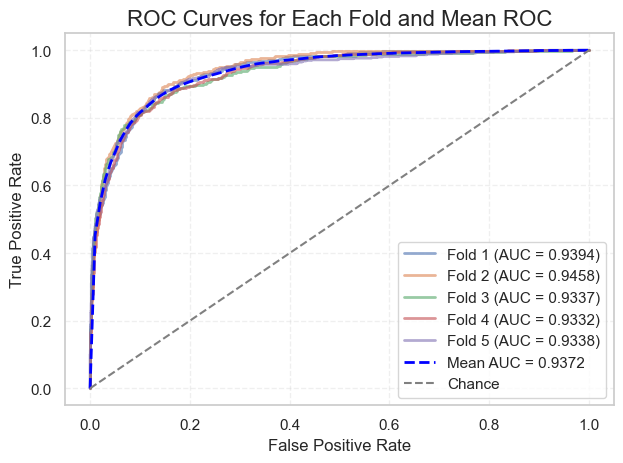

Mean AUC across folds: 0.9371782572493936
Fichier de soumission enregistré : 'resultats\submission_catboost14_kfold.csv'


In [594]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")
    
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=3,
        class_weights=[1, 2.5],
        random_state=42,
        verbose=0,
        loss_function='Logloss',
        eval_metric='AUC'
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
    
    y_val_pred = model.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    final_predictions += model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")

submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_catboost14_kfold.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_catboost14_kfold.csv'")

In [595]:
feature_importances = model.get_feature_importance()
feature_names = X.columns
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.4f}")


CreditScore: 0.3295
Age: 24.3221
Tenure: 0.4827
Balance: 1.3947
NumOfProducts: 44.4389
HasCrCard: 0.1481
IsActiveMember: 2.9175
EstimatedSalary: 0.3195
Geography_Germany: 5.8831
Geography_Spain: 0.0000
Gender_Male: 3.8494
Log_Balance: 1.4661
Inactive_high_balance: 0.0885
Age_Balance: 1.3413
Tenure_NumOfProducts: 0.8735
NumOfProducts_IsActiveMember: 8.3210
Balance / EstimatedSalary: 1.9381
Balance_per_Product_Age: 1.8861


## Correlation

In [596]:
correlation_threshold = 0.5  
correlation_matrix = train_encoded.corr()
high_correlation_pairs = (
    correlation_matrix
    .unstack()  
    .reset_index()  
)
high_correlation_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[
    (high_correlation_pairs['Correlation'].abs() > correlation_threshold) & 
    (high_correlation_pairs['Variable1'] != high_correlation_pairs['Variable2'])
]
high_correlation_pairs = high_correlation_pairs.drop_duplicates(subset=['Correlation'])
high_correlation_pairs = high_correlation_pairs.sort_values(by="Correlation", ascending=False)
print(high_correlation_pairs)


                 Variable1                     Variable2  Correlation
69                 Balance                   Log_Balance     0.979184
71                 Balance                   Age_Balance     0.965689
242            Log_Balance                   Age_Balance     0.946612
75                 Balance       Balance_per_Product_Age     0.926382
130         IsActiveMember  NumOfProducts_IsActiveMember     0.910834
246            Log_Balance       Balance_per_Product_Age     0.905562
284            Age_Balance       Balance_per_Product_Age     0.838834
53                  Tenure          Tenure_NumOfProducts     0.826544
183      Geography_Germany                   Log_Balance     0.634922
185      Geography_Germany                   Age_Balance     0.624681
66                 Balance             Geography_Germany     0.616645
70                 Balance         Inactive_high_balance     0.599239
261  Inactive_high_balance                   Age_Balance     0.595582
241            Log_B

In [597]:
train_encoded = train_encoded.drop(columns=["Balance_per_Product_Age"])
test_encoded = test_encoded.drop(columns=["Balance_per_Product_Age"])

## Stacking

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


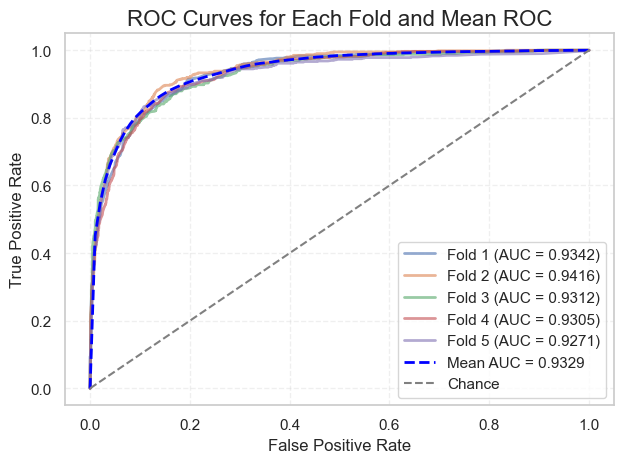

Mean AUC across folds: 0.9329207265962868
Fichier de soumission enregistré : 'resultats\submission_stacking.csv'


In [598]:
X = train_encoded.drop(columns=["Exited"])
y = train_encoded["Exited"]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
final_predictions = np.zeros(len(test))

base_learners = [
    ('catboost', CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Méta-modèle : CatBoost
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.05, max_depth=3, random_state=42)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    stacking_model.fit(X_train, y_train)
    
    y_val_pred = stacking_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f"Fold {fold + 1} (AUC = {auc:.4f})")
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    final_predictions += stacking_model.predict_proba(test_encoded)[:, 1] / kf.n_splits
    

    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)
plt.plot(mean_fpr, mean_tpr, color="blue", linestyle="--", lw=2, label=f"Mean AUC = {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("ROC Curves for Each Fold and Mean ROC", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {np.mean(auc_scores)}")



submission = pd.DataFrame({
    'id': test['id'],
    'Exited': final_predictions
})
submission.to_csv('resultats\submission_stacking.csv', index=False)
print("Fichier de soumission enregistré : 'resultats\submission_stacking.csv'")
